# 1 - Paper - Sequence to Sequence Learning with Neural Networks


- **Author:** Ilya Sutskever, Oriol Vinyals, Quoc V. Le
- **Conference**:  NIPS 2014

[aRxiv_link](https://arxiv.org/abs/1409.3215)

[Code_github](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

In [ ]:
!pip install torchviz


In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import os
import time

In [ ]:
torch.cuda.is_available()

True

## Making the model deterministic

In [ ]:
SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#!python -m spacy download en
!python -m spacy download de


    Linking successful
    /usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/de

    You can now load the model via spacy.load('de')



In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
sent_en = "I am Sankarshan. I live in Bangalore. !!"
sent_de = "Ich bin sankarshan. Ich wohne in Bangalore. !!"

print(tokenize_en(sent_en))
print(tokenize_de(sent_de))

['I', 'am', 'Sankarshan', '.', 'I', 'live', 'in', 'Bangalore', '.', '!', '!']
['!', '!', '.', 'Bangalore', 'in', 'wohne', 'Ich', '.', 'sankarshan', 'bin', 'Ich']


In [ ]:
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

## Downloading the dataset

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
exam = vars(train_data.examples[0])
print("Source GERMAN (reversed): {}".format(exam['src']))
print("Target ENGLISH: {}".format(exam['trg']))

Source GERMAN (reversed): ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']
Target ENGLISH: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


## Vocabulary Building

- one hot encoding is used. 
- no word embedding.

In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        #embedded = [src sent len, batch size, emb dim]
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        embedded = self.dropout(self.embedding(src))
        
        
        
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
#summary(model, [(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS),(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS)])

#summary(model, [(INPUT_DIM, ENC_EMB_DIM, HID_DIM),(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,898,501 trainable parameters


In [ ]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
pad_idx = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)



In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 2
CLIP = 1
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'tut1_model.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

In [ ]:

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 17s
	Train Loss: 4.820 | Train PPL: 124.003
	 Val. Loss: 4.810 |  Val. PPL: 122.679
Epoch: 02 | Time: 1m 17s
	Train Loss: 4.389 | Train PPL:  80.562
	 Val. Loss: 4.574 |  Val. PPL:  96.950


In [ ]:
enumerate(train_iterator)

In [ ]:
#train_iterator

for i, batch in enumerate(train_iterator):
        
  src = batch.src
  trg = batch.trg

  optimizer.zero_grad()

  output = model(src, trg)

#make_dot(output, params=dict(Seq2Seq.named_parameters()))

In [ ]:
src.shape, trg.shape

(torch.Size([28, 128]), torch.Size([28, 128]))

In [ ]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.637 | Test PPL: 103.201 |


## Model Summary

In [ ]:
#??summary

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print("name: {}, params: {}, shape: {}".format(name, "-NA-", param.data.shape))

name: encoder.embedding.weight, params: -NA-, shape: torch.Size([7853, 256])
name: encoder.rnn.weight_ih_l0, params: -NA-, shape: torch.Size([2048, 256])
name: encoder.rnn.weight_hh_l0, params: -NA-, shape: torch.Size([2048, 512])
name: encoder.rnn.bias_ih_l0, params: -NA-, shape: torch.Size([2048])
name: encoder.rnn.bias_hh_l0, params: -NA-, shape: torch.Size([2048])
name: encoder.rnn.weight_ih_l1, params: -NA-, shape: torch.Size([2048, 512])
name: encoder.rnn.weight_hh_l1, params: -NA-, shape: torch.Size([2048, 512])
name: encoder.rnn.bias_ih_l1, params: -NA-, shape: torch.Size([2048])
name: encoder.rnn.bias_hh_l1, params: -NA-, shape: torch.Size([2048])
name: decoder.embedding.weight, params: -NA-, shape: torch.Size([5893, 256])
name: decoder.rnn.weight_ih_l0, params: -NA-, shape: torch.Size([2048, 256])
name: decoder.rnn.weight_hh_l0, params: -NA-, shape: torch.Size([2048, 512])
name: decoder.rnn.bias_ih_l0, params: -NA-, shape: torch.Size([2048])
name: decoder.rnn.bias_hh_l0, para

## Visualize the network

[torchviz](https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb)

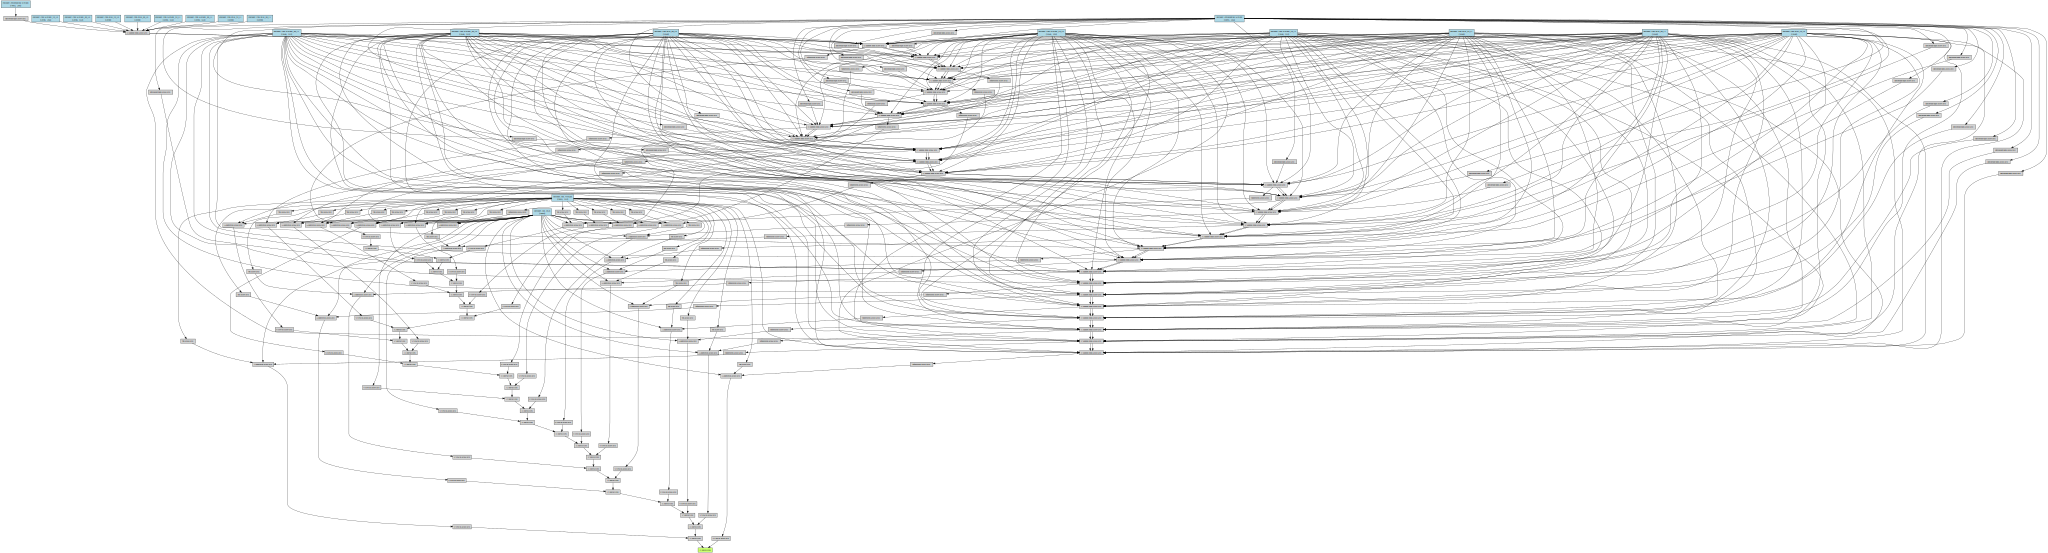

In [ ]:
make_dot(output, params=dict(model.named_parameters()))

In [ ]:
#dict(model.named_parameters())